# Exercise 03

In [2]:
import pandas as pd
import sqlite3

In [3]:
connection = sqlite3.connect('../data/checking-logs.sqlite')

## 1. analyze only the users and not the admins


In [4]:
sql_query = '''
SELECT uid, timestamp
FROM checker
WHERE uid LIKE "user_%"
'''

df = pd.read_sql(sql_query, connection)
df

,uid,timestamp
0,user_4,2020-04-17 05:19:02.744528
1,user_4,2020-04-17 05:22:35.249331
2,user_4,2020-04-17 05:22:45.549397
3,user_4,2020-04-17 05:34:14.691200
4,user_4,2020-04-17 05:34:24.422370
...,...,...
3202,user_1,2020-05-21 20:19:06.872761
3203,user_1,2020-05-21 20:22:41.785725
3204,user_1,2020-05-21 20:22:41.877806
3205,user_1,2020-05-21 20:37:00.129678


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['timestamp'] = pd.to_datetime(df['timestamp'].dt.date)
df['day_type'] = df['timestamp'].dt.dayofweek
df

,uid,timestamp,hour,day_type
0,user_4,2020-04-17,5,4
1,user_4,2020-04-17,5,4
2,user_4,2020-04-17,5,4
3,user_4,2020-04-17,5,4
4,user_4,2020-04-17,5,4
...,...,...,...,...
3202,user_1,2020-05-21,20,3
3203,user_1,2020-05-21,20,3
3204,user_1,2020-05-21,20,3
3205,user_1,2020-05-21,20,3


In [6]:
working_day = df[~df['day_type'].isin([5, 6])]
working_day.drop(['day_type'], axis=1, inplace=True)
weekend_day = df[df['day_type'].isin([5, 6])]
weekend_day.drop(['day_type'], axis=1, inplace=True)

/tmp/ipykernel_18950/4121171674.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_day.drop(['day_type'], axis=1, inplace=True)
/tmp/ipykernel_18950/4121171674.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekend_day.drop(['day_type'], axis=1, inplace=True)


In [7]:
working = working_day.groupby(['timestamp', 'hour']).count().reset_index()
working = working.groupby(['hour']).mean('uid').reset_index()
working['uid'] = working['uid'].astype(int)
working.rename(columns={'uid': 'working_day'}, inplace=True)

In [8]:
for hour in range(0, 24):
    if hour not in working['hour'].values:
        new_row = pd.DataFrame({'hour': [hour], 'working_day': [0]})
        working = pd.concat([working, new_row], ignore_index=True)

In [9]:
working

,hour,working_day
0,0,3
1,3,2
2,5,7
3,6,1
4,7,5
5,8,3
6,9,6
7,10,13
8,11,6
9,12,7


In [10]:
weekend = weekend_day.groupby(['timestamp', 'hour']).count().reset_index()
weekend = weekend.groupby(['hour']).mean('uid').reset_index()
weekend['uid'] = weekend['uid'].astype(int)
weekend.rename(columns={'uid': 'weekend'}, inplace=True)

In [11]:
for hour in range(0, 24):
    if hour not in weekend['hour'].values:
        new_row = pd.DataFrame({'hour': [hour], 'weekend': [0]})
        weekend = pd.concat([weekend, new_row], ignore_index=True)

In [12]:
weekend

,hour,weekend
0,0,2
1,1,6
2,3,1
3,5,2
4,7,4
5,8,7
6,9,3
7,10,7
8,11,23
9,12,9


In [13]:
result = pd.merge(weekend, working, on='hour', how='inner')
result = result.set_index('hour').sort_index()
result

,weekend,working_day
hour,,
0,2,3
1,6,0
2,0,0
3,1,2
4,0,0
5,2,7
6,0,1
7,4,5
8,7,3


## 2. the fontsize and the figsize remain the same
## 3. for each hour, calculate the average number of commits on working days and on weekends (if there were no commits in an hour, do not use it to calculate the average) use these values for your graph, for example: Mon, 17-18: 5 commits, Tue, 17-18: 6 commits, Wed, 17-18: 7 commits
## 4. choose a palette that you really enjoy, you do not have to replicate it from the graph above

array([<Axes: title={'center': 'weekend'}, xlabel='hour'>,
       <Axes: title={'center': 'working_day'}, xlabel='hour'>],
      dtype=object)

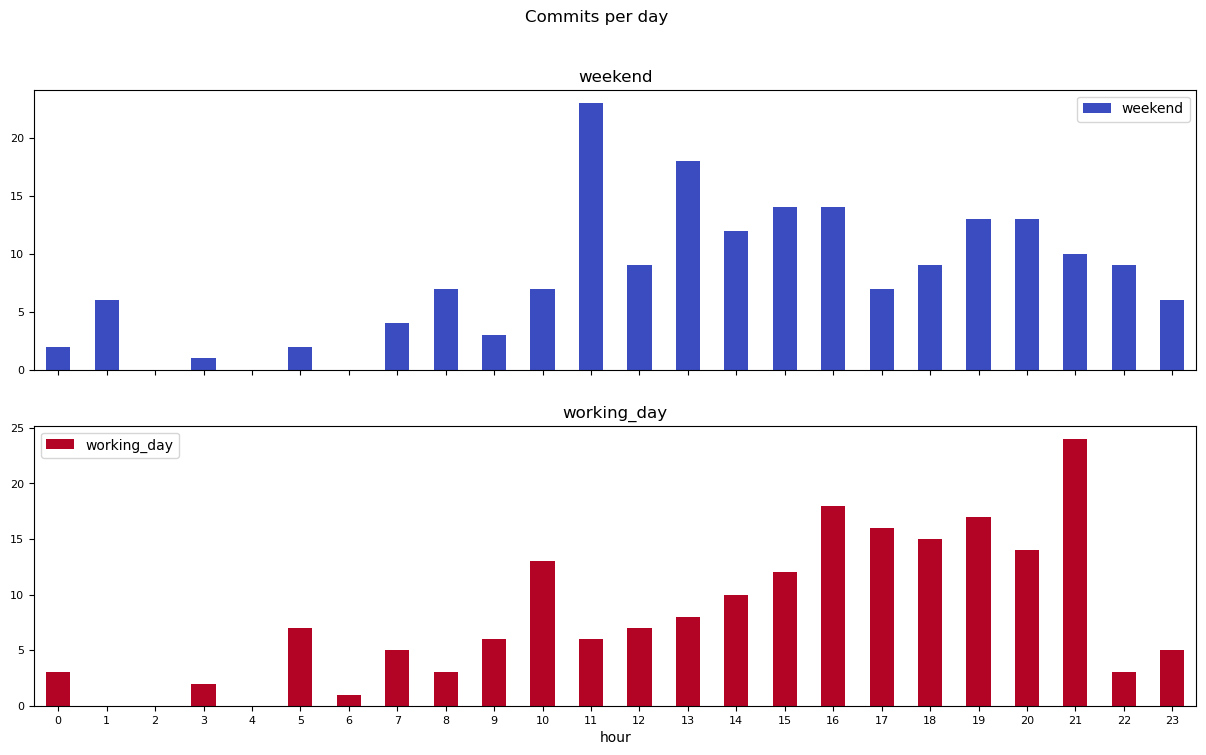

In [14]:
result.plot(kind='bar', subplots=True, figsize=(15, 8), fontsize=8, rot=0, title='Commits per day', colormap='coolwarm')

In [15]:
connection.close()

## 5. at the end of your Jupyter Notebook, create a markdown cell and insert the question

- Is the dynamic different on working days and weekends?


In [16]:
hour_working = result.index[result['working_day'] == result['working_day'].max()].item()
print(f'the largest number of comments occurs on weekdays at {hour_working} hour')

the largest number of comments occurs on weekdays at 21 hour


In [17]:
hour_weekend = result.index[result['weekend'] == result['weekend'].max()].item()
print(f'the largest number of comments occurs on weeknd at {hour_weekend} hour')

the largest number of comments occurs on weeknd at 11 hour
